In [1]:
# !pip install beautifulsoup4
!pip install GoogleNews
# !pip install lxml
!pip install googlesearch-python
!pip install yfinance
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.2/293.2 kB 525.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 270.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.8/115.8 kB 539.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.3
    Uninstalling idna-3.3:
      Successfully uninstalled idna-3.3
  Attempting uninstall: chardet
    Found existing installation: chardet 5.0.0
    Uninstalling chardet-5.0.0:
      Successfully uninstalled chardet-5.0.0
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.1
    Uninstalling beautifulsoup4-4.11.1:
      Successfully uninstalled beautifulsoup4-4.11.1
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:

In [2]:
import requests, time
from bs4 import BeautifulSoup
import csv, re
from GoogleNews import GoogleNews
import urllib.request

In [3]:
googlenews = GoogleNews()
googlenews.set_lang('en')
googlenews.set_period('1d')
googlenews.set_encode('utf-8')

In [4]:
query = "APPLE"

googlenews.get_news(query)

https://news.google.com/search?q=APPLE%2Bwhen%3A1d&hl=en


In [5]:
query_news_result = googlenews.results()
titles = []
descs = []
links = []
datetimes = []

for i, news in enumerate(query_news_result):
    titles.append(news["title"])
    descs.append(news["desc"])
    links.append(news["link"])
    datetimes.append(news["datetime"])

In [6]:
import pandas as pd, numpy as np, datetime

df = pd.DataFrame({"Title":titles, "Descrition":descs, "Link":links, "Datetime":datetimes})
df = df[df["Datetime"].notnull()]
df = df.sort_values(by = "Datetime")
df.head()

,Title,Descrition,Link,Datetime
43,MacBook owners can now claim payout in class a...,None,news.google.com/./articles/CBMiSWh0dHBzOi8vOXR...,2023-01-04 02:28:52.188512
40,Stock Market Hits Resistance To Start 2023 As ...,None,news.google.com/./articles/CBMif2h0dHBzOi8vd3d...,2023-01-04 03:28:52.187227
95,Phone production worries knock Apple off its p...,None,news.google.com/./articles/CBMie2h0dHBzOi8vd3d...,2023-01-04 03:28:52.210368
74,Apple has lost $1 trillion in market value in ...,None,news.google.com/./articles/CBMiTWh0dHBzOi8vd3d...,2023-01-04 04:28:52.201575
76,"This Day in History: da Vinci, Apple, and Ragi...",None,news.google.com/./articles/CBMiaWh0dHBzOi8vd3d...,2023-01-04 04:28:52.202459


In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize

tk = RegexpTokenizer(r'\w+')
nltk.download('stopwords')
stop = stopwords.words('english')

def clean_text(df, column):
    df[column+"_clean"] = df[column].str.lower()
    df[column+"_clean"] = df[column+"_clean"].apply(lambda x: ' '.join([word for word in tk.tokenize(x) if word not in (stop)]))
    
    return df

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# df = clean_text(df, "Title")
# df = clean_text(df, "Descrition")

In [9]:
df.head()

,Title,Descrition,Link,Datetime
43,MacBook owners can now claim payout in class a...,None,news.google.com/./articles/CBMiSWh0dHBzOi8vOXR...,2023-01-04 02:28:52.188512
40,Stock Market Hits Resistance To Start 2023 As ...,None,news.google.com/./articles/CBMif2h0dHBzOi8vd3d...,2023-01-04 03:28:52.187227
95,Phone production worries knock Apple off its p...,None,news.google.com/./articles/CBMie2h0dHBzOi8vd3d...,2023-01-04 03:28:52.210368
74,Apple has lost $1 trillion in market value in ...,None,news.google.com/./articles/CBMiTWh0dHBzOi8vd3d...,2023-01-04 04:28:52.201575
76,"This Day in History: da Vinci, Apple, and Ragi...",None,news.google.com/./articles/CBMiaWh0dHBzOi8vd3d...,2023-01-04 04:28:52.202459


## Retrive News

In [10]:
from googlesearch import search
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [11]:
def get_news_corpus(news_title):
    result = search(news_title)
    attempt = 0
    error_occur = False
    sents = []
    
    while (not error_occur) and (attempt < 5):
        try:
            news_link = result[attempt]
            scraped_data = urllib.request.urlopen(news_link)
            article = scraped_data.read()
            parsed_article = BeautifulSoup(article, 'lxml')
            paragraphs = parsed_article.find_all('p')
            article_text = ""
    
            for p in paragraphs:
                article_text += p.text
    
            article_text = sent_tokenize(article_text)
    
            for t in article_text:
                t = re.sub(r"\s+", " ", t) # remove \n and \t
                t = re.sub(r"[^\w\s]", "", t) # remove punctuations
                t = re.sub(r"[0-9]+", "", t) # remove numbers
                sents.append(t)
        
            error_occur = True
        except:
            time.sleep(5) # avoid all HTTP error
            attempt += 1
        
    return sents

## Article Summary

In [12]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# num_news = 10
# polarity_score = []
# for news_title in df["Title"]:
#     article = get_news_corpus(news_title)
#     passage = " ".join(article)
#     polarity_score.append(sia.polarity_scores(passage)['compound'])

# print(polarity_score)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Stock Price

In [13]:
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
import cufflinks as cf

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.



In [14]:
cf.go_offline() #will make cufflinks offline
cf.set_config_file(offline=False, world_readable=True)

### Plotly figure

In [15]:
stock = yf.Ticker('AAPL')
price_history = stock.history(period = '1d', interval = '1m')

# fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig = go.Figure(data = [go.Candlestick(x = price_history.index,
#                 open = price_history['Open'].values,
#                 high = price_history['High'].values,
#                 low = price_history['Low'].values,
#                 close = price_history['Close'].values)])
# fig = go.Figure(data=[go.Candlestick(x=price_history.index,
#                 open=price_history['Open'], high=price_history['High'],
#                 low=price_history['Low'], close=price_history['Close'])])

# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

In [16]:
# fig = go.Figure(data = [go.Scatter(x = price_history.index,
#                          y = price_history["Volume"],
#                          mode = "lines+markers")])

# fig.show()

### Cufflinks figure

In [17]:
qf = cf.QuantFig(price_history, title="Apple's stock price", name='AAPL')
# qf.add_sma(periods=14, column='Close', color='blue')
qf.add_volume()
qf.add_ema()
qf.iplot(up_color="green", down_color="red")

## Reuters News

In [18]:
def scrape_reuters_news(ticker, date_range = "pastWeek"):
    # date_range can be: pastDay, pastWeek, pastMonth, and pastYear
    print(f"Search {ticker}'s {date_range} news")
    with requests.Session() as s:
        r = s.get(f'https://www.reuters.com/search/news?sortBy=date&dateRange={date_range}&blob={ticker}')
        soup = BeautifulSoup(r.content, 'lxml')
        num_results = soup.select_one('.search-result-count-num').text
        r = s.get(f'https://www.reuters.com/assets/searchArticleLoadMoreJson?blob={ticker}&bigOrSmall=big&articleWithBlog=true&sortBy=relevance&dateRange={date_range}&numResultsToShow={num_results}&pn=&callback=addMoreNewsResults')
        p = re.compile(r'id: "(.*?)"')
        p2 = re.compile(r'headline: "(.*?)"')
        links = [f'https://www.reuters.com/article/id{i}' for i in p.findall(r.text)]
        headlines = [BeautifulSoup(i, 'lxml').get_text() for i in p2.findall(r.text)]
    
    articles = []    
    cleaned_articles = []
    for link in links:
        paragraphs = ""
        scraped_data = urllib.request.urlopen(link)
        scraped_data = scraped_data.read()
        parsed_article = BeautifulSoup(scraped_data, 'lxml')
        article = parsed_article.find_all("p")
        
        for paragraph in article:
            paragraphs +=  paragraph.text + " "

        articles.append(paragraphs)
        paragraph_sents = sent_tokenize(paragraphs)
        sents = []
        
        for ps in paragraph_sents:
            ps = re.sub(r"\s+", " ", ps) # remove \n and \t
            ps = re.sub(r"[^\w\s]", "", ps) # remove punctuations
            ps = re.sub(r"[0-9]+", "", ps) # remove numbers
            ps = " ".join([word for word in tk.tokenize(ps.lower()) if word not in (stop)]) # remove stop words
            sents.append(ps)
            
        cleaned_articles.append(" ".join(sents))
        
    return headlines, articles, cleaned_articles

## Yahoo News

In [19]:
stock = yf.Ticker('AAPL')

In [20]:
def scrape_yahoo_news(url):
    scraped_data = requests.get(url).content
    parsed_article = BeautifulSoup(scraped_data)

    article_text = ""
    article = parsed_article.find_all("p")
    
    paragraphs = ""
    for paragraph in article:
            paragraphs +=  paragraph.text + " "
            
    paragraph_sents = sent_tokenize(paragraphs)
    sents = []
        
    for ps in paragraph_sents:
        ps = re.sub(r"\s+", " ", ps) # remove \n and \t
        ps = re.sub(r"[^\w\s]", "", ps) # remove punctuations
        ps = re.sub(r"[0-9]+", "", ps) # remove numbers
        ps = " ".join([word for word in tk.tokenize(ps.lower()) if word not in (stop)]) # remove stop words
        sents.append(ps)
            
    return sents

for i, new in enumerate(stock.news):
    print(scrape_yahoo_news(new["link"]))

['reuters apple inc set sign chinese contract manufacturer luxshare precision industry co ltd produce premium iphone models financial times reported wednesday citing sources familiar matter', 'luxshare producing small numbers iphone pro max kunshan plant make lost production foxconns zhengzhou factory last year report added', 'analysts expected apple diversify supplier base amid production disruptions china due employee unrest factory operated foxconn covid induced lockdowns', 'apple november warned lower shipments premium iphone models following significant production cuts', 'iphone maker luxshare immediately respond reuters requests comment', 'reporting akash sriram bengaluru editing shailesh kuber related quotes']
['adds details report background production disruption jan reuters apple inc set sign chinese contract manufacturer luxshare precision industry co ltd produce premium iphone models financial times reported wednesday citing sources familiar matter', 'luxshare producing smal

In [21]:
from datetime import datetime
from pytz import timezone
import pytz

date = datetime.now(tz=pytz.utc)
today = date.astimezone(timezone('US/Pacific')).strftime("%Y-%m-%d")
today

'2023-01-04'

In [22]:
def plot_stock_history(ticker, date = today):
    stock = yf.Ticker(ticker)
    price_history = stock.history(period = '1d', interval = '1m')
    qf = cf.QuantFig(price_history, title=f"{ticker}'s stock price", name=ticker)
#     qf.add_resistance(date = "21Dec22", color="orange")
    qf.add_volume()
    qf.add_ema()
    qf.iplot(up_color="green", down_color="red")

### Apple

In [23]:
ticker = "apple"
news = scrape_reuters_news(ticker)

news_data = pd.DataFrame({"title":news[0], "article":news[1], "cleaned_article":news[2]}).drop_duplicates()

article_polarity = []

for article in news_data["article"]:
    article_polarity.append(sia.polarity_scores(article)["compound"])
    
news_data["article_polarity"] = article_polarity

news_data.head()

Search apple's pastWeek news


,title,article,cleaned_article,article_polarity
0,Apple<\/b> to sign Luxshare for iPhone product...,Jan 4 (Reuters) - Apple Inc (AAPL.O) is set to...,jan reuters apple inc aaplo set sign chinese c...,0.3551
1,Apple<\/b> to sign Luxshare for iPhone product...,Discover Thomson Reuters By Reuters Staff 1 Mi...,discover thomson reuters reuters staff min rea...,0.3612
2,Apple's<\/b> stock market value falls below $2...,Jan 3 (Reuters) - Apple Inc's (AAPL.O) stock m...,jan reuters apple incs aaplo stock market valu...,0.6915
3,Luxshare says client cooperation normal after ...,Discover Thomson Reuters By Reuters Staff 1 Mi...,discover thomson reuters reuters staff min rea...,-0.6124
4,UPDATE 2-Apple<\/b> to sign Luxshare for iPhon...,Discover Thomson Reuters By Reuters Staff 2 Mi...,discover thomson reuters reuters staff min rea...,-0.2023


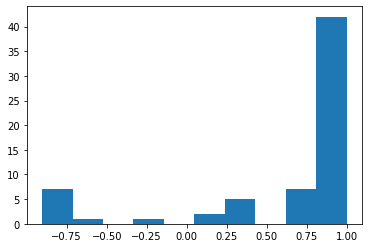

In [24]:
plt.figure()
plt.hist(news_data.article_polarity)
plt.show()

In [25]:
plot_stock_history("AAPL")

### GameStop

In [26]:
ticker = "gamestop"
news = scrape_reuters_news(ticker)

news_data = pd.DataFrame({"title":news[0], "article":news[1], "cleaned_article":news[2]}).drop_duplicates()

article_polarity = []

for article in news_data["article"]:
    article_polarity.append(sia.polarity_scores(article)["compound"])
    
news_data["article_polarity"] = article_polarity

news_data.head()

Search gamestop's pastWeek news


,title,article,cleaned_article,article_polarity


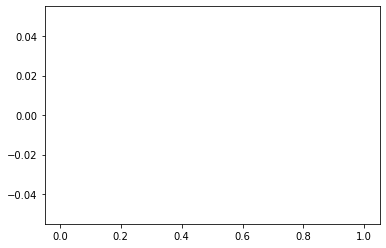

In [27]:
plt.figure()
plt.hist(news_data.article_polarity)
plt.show()

In [28]:
plot_stock_history("GME")

### Nokia

In [29]:
ticker = "nokia"
news = scrape_reuters_news(ticker)

news_data = pd.DataFrame({"title":news[0], "article":news[1], "cleaned_article":news[2]}).drop_duplicates()

article_polarity = []

for article in news_data["article"]:
    article_polarity.append(sia.polarity_scores(article)["compound"])
    
news_data["article_polarity"] = article_polarity

news_data.head()

Search nokia's pastWeek news


,title,article,cleaned_article,article_polarity
0,China's Huawei sees 'business as usual' as U.S...,"SHANGHAI, Dec 30 (Reuters) - Chinese tech gian...",shanghai dec reuters chinese tech giant huawei...,0.886
1,UPDATE 3-China's Huawei sees 'business as usua...,"SHANGHAI, Dec 30 (Reuters) - Chinese tech gian...",shanghai dec reuters chinese tech giant huawei...,0.886


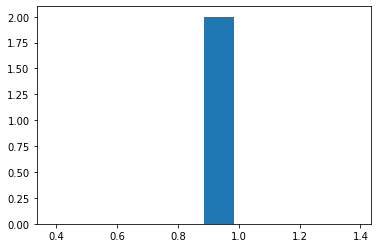

In [30]:
plt.figure()
plt.hist(news_data.article_polarity)
plt.show()

In [31]:
plot_stock_history("NOK")